In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, PReLU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V&authuser=0&export=download --folder

/bin/bash: --folder: command not found
Downloading...
From: https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V
To: /content/dataset.zip
100% 242M/242M [00:01<00:00, 205MB/s]


In [ ]:
!ls

best_model.h5  dataset	dataset.zip  sample_data


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/COVID/Covid (937).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/COVID/Covid (937).png  
  inflating: dataset/COVID/Covid (936).png  
  inflating: dataset/COVID/Covid (922).png  
  inflating: dataset/COVID/Covid (952).png  
  inflating: dataset/COVID/Covid (997).png  
  inflating: dataset/COVID/Covid (934).png  
  inflating: dataset/COVID/Covid (956).png  
  inflating: dataset/COVID/Covid (975).png  
  inflating: dataset/COVID/Covid (978).png  
  inflating: dataset/COVID/Covid (875).png  
  inflating: dataset/COVID/Covid (901).png  
  inflating: dataset/COVID/Covid (99).png  
  inflating: dataset/COVID/Covid (912).png  
  inflating: dataset/COVID/Covid (867).png  
  inflating: dataset/COVID/Covid (900).png  
  inflating: dataset/COVID/Covid (94).png  
  inflating: dataset/COVID/Covid (921).png  
  inflating: dataset/COVID/Covid (89).png  
  inflating: dataset/COVID/Covid (874).png  
  inflating: dataset/COVID/Covid (95).png  
  i

In [ ]:
!ls
!rm -rf dataset.zip
!ls

best_model.h5  dataset	dataset.zip  sample_data
best_model.h5  dataset	sample_data


In [ ]:
covid_class = ['COVID', 'non-COVID']
data_dir = 'dataset/'
train_dir = os.path.join(data_dir)
IMAGE_SIZE = 64

In [ ]:
def create_data_frame():
    train_data = []
    for defects_id, sp in enumerate(covid_class):
        for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
    return pd.DataFrame(train_data, columns=[
        'file', 'id_class', 'class'])

In [ ]:
def random_data_frame(data):
    data = data.sample(frac=1, random_state=42)
    data.index = np.arange(len(data))
    return data

In [ ]:
def read_image(filepath):  # Loading a color image is the default flag
    return cv2.imread(os.path.join(data_dir, filepath))

In [ ]:
def resize_image(image, image_size):  # Resize image to target size
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
def load_images(data):
    X_train = np.zeros((data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for i, file in tqdm(enumerate(data['file'].values)):
        image = read_image(file)
        if image is not None:
            X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
    images = X_train / 255.  # Normalize the data
    print("Total de imagens carregadas: " + str(len(images)))
    return images

In [ ]:
def image_data_gen():
    return ImageDataGenerator(
        rotation_range=20,  # Rotaciona aleatoriamente as imagens no intervalo de 0 a 20 graus
        width_shift_range=0.2,  # Desloca horizontalmente as imagens em até 10% do tamanho total
        height_shift_range=0.2,  # Desloca verticalmente as imagens em até 10% do tamanho total
        zoom_range=0.2,  # Aplica zoom aleatório nas imagens
        horizontal_flip=True,  # Realiza espelhamento horizontal aleatório nas imagens
        vertical_flip=True,
        fill_mode='nearest',  # Preenche pixels ausentes após transformações
    )

In [ ]:
def create_model():
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation=PReLU())(x)
    x = Dropout(0.3)(x)

    output = Dense(2, activation='softmax', name='root')(x)
    model = Model(input, output)
    optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
def classification_summary(y_test, pred, pred_prob):
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred), 3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'), 3)*100))
    print("AUC score: {:.3f}".format(round(roc_auc_score(y_test, pred_prob), 3)*100))
    print('Recal Score = {}%'.format(round(recall_score(y_test, pred, average='weighted'), 3)*100))
    print('Precision = {}%'.format(round(precision_score(y_test, pred, average='weighted'), 3)*100))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

In [ ]:
data = create_data_frame()
print(data)

                                file  id_class      class
0              COVID/Covid (506).png         0      COVID
1              COVID/Covid (472).png         0      COVID
2              COVID/Covid (723).png         0      COVID
3              COVID/Covid (451).png         0      COVID
4              COVID/Covid (160).png         0      COVID
...                              ...       ...        ...
2476   non-COVID/Non-Covid (734).png         1  non-COVID
2477   non-COVID/Non-Covid (648).png         1  non-COVID
2478   non-COVID/Non-Covid (673).png         1  non-COVID
2479  non-COVID/Non-Covid (1025).png         1  non-COVID
2480   non-COVID/Non-Covid (930).png         1  non-COVID

[2481 rows x 3 columns]


In [ ]:
data = random_data_frame(data)
print(data)

                               file  id_class      class
0             COVID/Covid (966).png         0      COVID
1             COVID/Covid (566).png         0      COVID
2     non-COVID/Non-Covid (328).png         1  non-COVID
3     non-COVID/Non-Covid (837).png         1  non-COVID
4            COVID/Covid (1204).png         0      COVID
...                             ...       ...        ...
2476  non-COVID/Non-Covid (320).png         1  non-COVID
2477          COVID/Covid (386).png         0      COVID
2478         COVID/Covid (1047).png         0      COVID
2479  non-COVID/Non-Covid (493).png         1  non-COVID
2480          COVID/Covid (453).png         0      COVID

[2481 rows x 3 columns]


In [ ]:
images = load_images(data)

2481it [00:12, 195.10it/s]


Total de imagens carregadas: 2481


In [ ]:
categories = to_categorical(data['id_class'].values, num_classes=2)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, categories, test_size=0.2)

In [ ]:
datagen = image_data_gen()

In [ ]:
datagen.fit(train_images)

In [ ]:
model = create_model()

In [ ]:
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          epochs=100,
          callbacks=[model_checkpoint],
          validation_data=(test_images, test_labels))

Epoch 1/100
62/62 [==============================] - 162s 2s/step - loss: 1.0476 - accuracy: 0.5706 - val_loss: 0.8401 - val_accuracy: 0.4990
Epoch 2/100
62/62 [==============================] - 136s 2s/step - loss: 0.7487 - accuracy: 0.6618 - val_loss: 0.6677 - val_accuracy: 0.6237
Epoch 3/100
62/62 [==============================] - 142s 2s/step - loss: 0.6383 - accuracy: 0.7001 - val_loss: 0.6559 - val_accuracy: 0.6620
Epoch 4/100
62/62 [==============================] - 139s 2s/step - loss: 0.5544 - accuracy: 0.7354 - val_loss: 0.4801 - val_accuracy: 0.7545
Epoch 5/100
62/62 [==============================] - 134s 2s/step - loss: 0.4984 - accuracy: 0.7777 - val_loss: 0.4562 - val_accuracy: 0.7746
Epoch 6/100
62/62 [==============================] - 134s 2s/step - loss: 0.4597 - accuracy: 0.7883 - val_loss: 0.2942 - val_accuracy: 0.8753
Epoch 7/100
62/62 [==============================] - 129s 2s/step - loss: 0.4015 - accuracy: 0.8226 - val_loss: 0.4058 - val_accuracy: 0.8410
Epoch 

In [ ]:
model = load_model('best_model.h5')

In [ ]:
_, accuracy = model.evaluate(test_images, test_labels)
print('Acuracia: {}'.format(accuracy))

16/16 [==============================] - 9s 434ms/step - loss: 0.0905 - accuracy: 0.9759
Acuracia: 0.9758551120758057


In [ ]:
rounded_labels = np.argmax(test_labels, axis=1)
predictions = model.predict(test_images).argmax(axis=1)

16/16 [==============================] - 8s 346ms/step


In [ ]:
classification_summary(rounded_labels, predictions.round().astype('int'), predictions)

Accuracy = 97.6%
F1 Score = 97.6%
AUC score: 97.500
Recal Score = 97.6%
Precision = 97.6%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       238
           1       0.96      0.99      0.98       259

    accuracy                           0.98       497
   macro avg       0.98      0.98      0.98       497
weighted avg       0.98      0.98      0.98       497



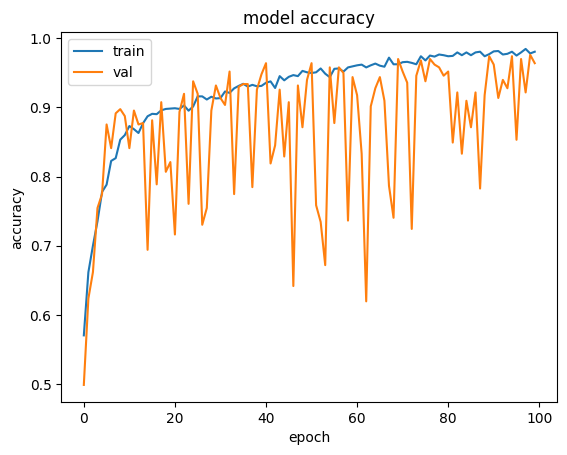

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

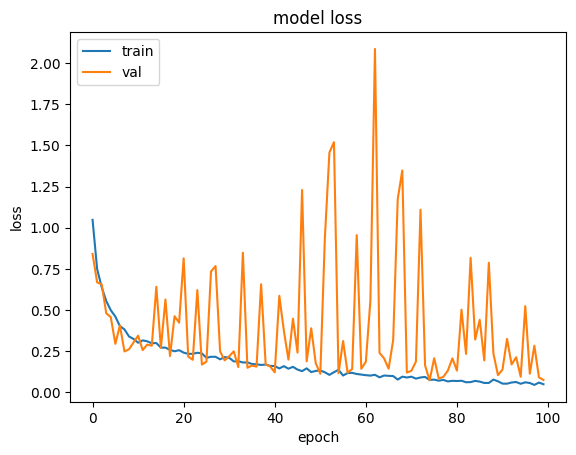

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

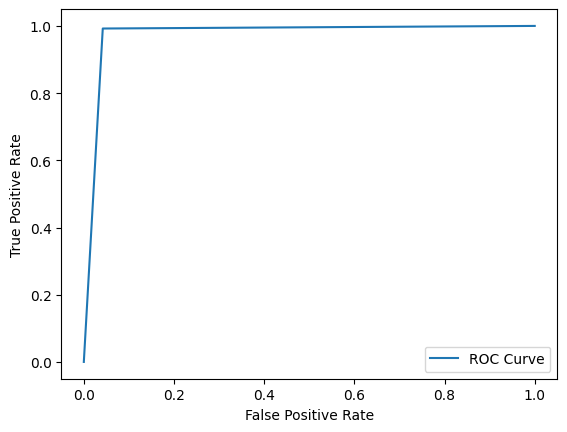

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    rounded_labels, predictions)
plt.plot(false_positive_rate, true_positive_rate,
         label='Best Model ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

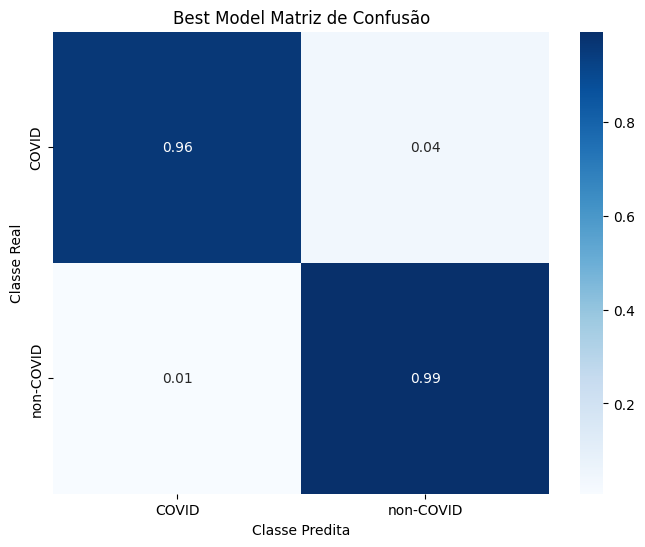

In [ ]:
# matriz de confusao
cm = confusion_matrix(rounded_labels, predictions)

# Normalizar a matriz de confusão
row_sums = cm.sum(axis=1)
normalized_confusion = cm / row_sums[:, np.newaxis]

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=covid_class, yticklabels=covid_class)
plt.title('Best Model Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()